# Code to build ML models on the diabetes dataset

/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:14:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


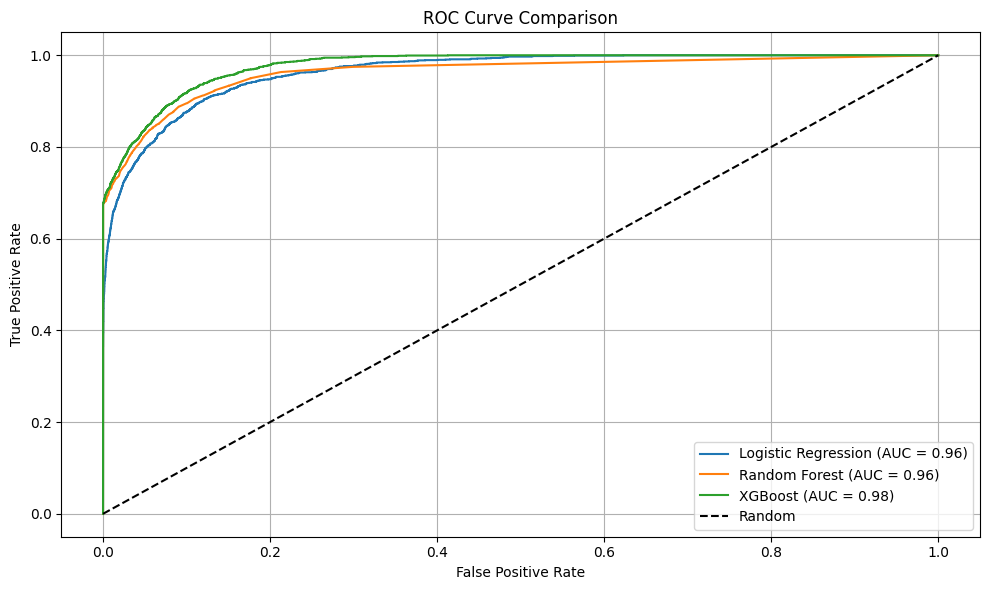

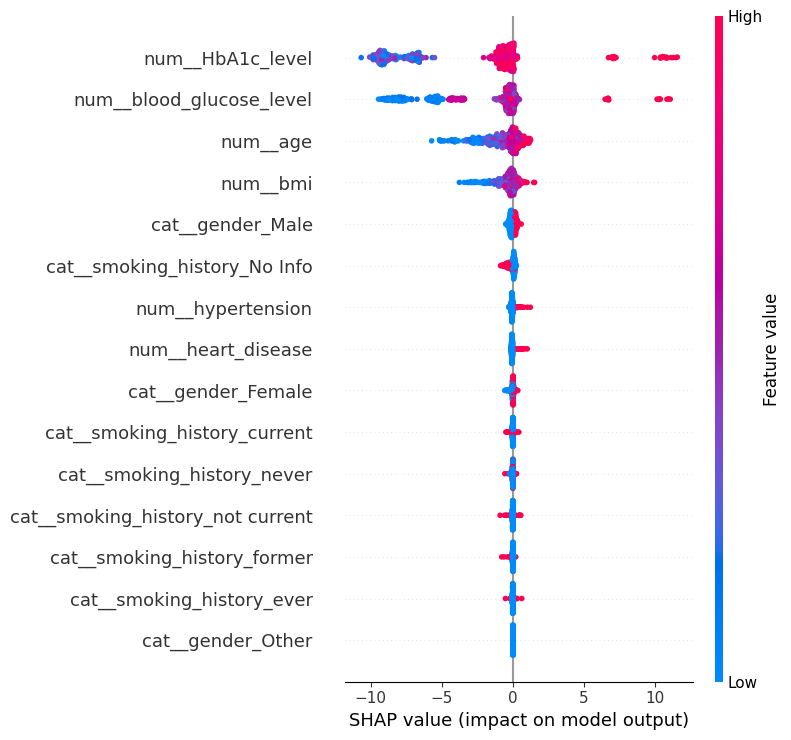

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# import shap

# # 1. Load Data
# df = pd.read_csv("diabetes_prediction_dataset.csv")
# df.dropna(subset=["diabetes"], inplace=True)
# X = df.drop(columns="diabetes")
# y = df["diabetes"]

# # 2. Column Identification
# categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
# numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# # 3. Pipelines for Transformation
# categorical_transformer = Pipeline([
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("onehot", OneHotEncoder(handle_unknown="ignore"))
# ])

# numerical_transformer = Pipeline([
#     ("imputer", SimpleImputer(strategy="mean")),
#     ("scaler", StandardScaler())
# ])

# preprocessor = ColumnTransformer([
#     ("num", numerical_transformer, numerical_cols),
#     ("cat", categorical_transformer, categorical_cols)
# ])

# # 4. Define Models with Class Balancing
# logreg = Pipeline([
#     ("preprocessor", preprocessor),
#     ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000))
# ])

# rf = Pipeline([
#     ("preprocessor", preprocessor),
#     ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
# ])

# scale_pos_weight = (y == 0).sum() / (y == 1).sum()
# xgb = Pipeline([
#     ("preprocessor", preprocessor),
#     ("classifier", XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss"))
# ])

# # 5. Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # 6. Train & Evaluate
# models = {"Logistic Regression": logreg, "Random Forest": rf, "XGBoost": xgb}
# results = {}

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_prob = model.predict_proba(X_test)[:, 1]
#     results[name] = {
#         "classification_report": classification_report(y_test, y_pred, output_dict=True),
#         "confusion_matrix": confusion_matrix(y_test, y_pred),
#         "roc_auc": roc_auc_score(y_test, y_prob),
#         "fpr": roc_curve(y_test, y_prob)[0],
#         "tpr": roc_curve(y_test, y_prob)[1]
#     }

# # 7. ROC Curve Plot
# plt.figure(figsize=(10, 6))
# for name in results:
#     plt.plot(results[name]["fpr"], results[name]["tpr"], label=f"{name} (AUC = {results[name]['roc_auc']:.2f})")
# plt.plot([0, 1], [0, 1], "k--", label="Random")
# plt.title("ROC Curve Comparison")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 8. SHAP for XGBoost - CPU Safe
# X_train_transformed = preprocessor.fit_transform(X_train)
# xgb_model = xgb.named_steps["classifier"]

# # SHAP TreeExplainer with interventional mode (CPU-friendly)
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(X_train_transformed[:500])  # Limit to 500 rows for speed

# # SHAP Summary Plot
# shap.summary_plot(shap_values, X_train_transformed[:500], feature_names=preprocessor.get_feature_names_out())


--- Data Loaded ---
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1 

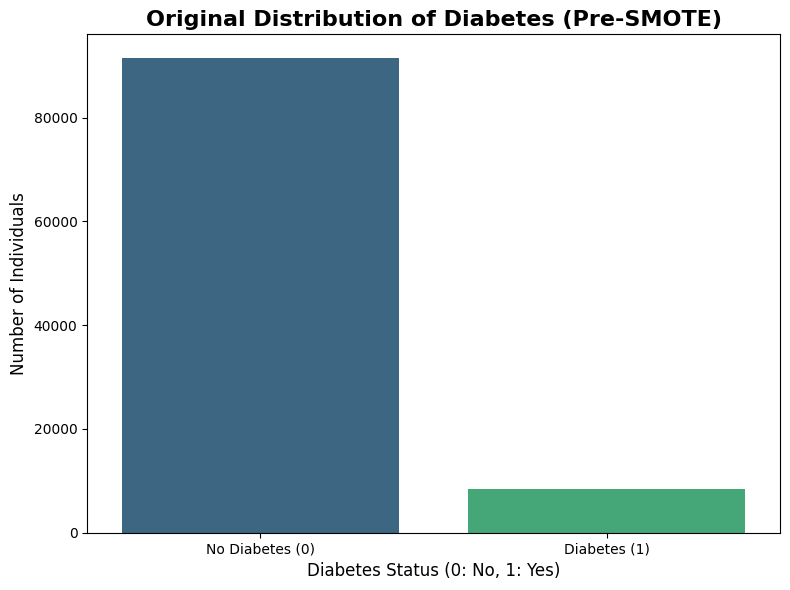


Training set class distribution:
0    0.915
1    0.085
Name: diabetes, dtype: float64
Test set class distribution:
0    0.915
1    0.085
Name: diabetes, dtype: float64

--- Applying Preprocessing and SMOTE to Training Data for Visualization ---

Training set size AFTER SMOTE: 146400 samples
Training set class distribution AFTER SMOTE:
1    0.5
0    0.5
Name: diabetes, dtype: float64


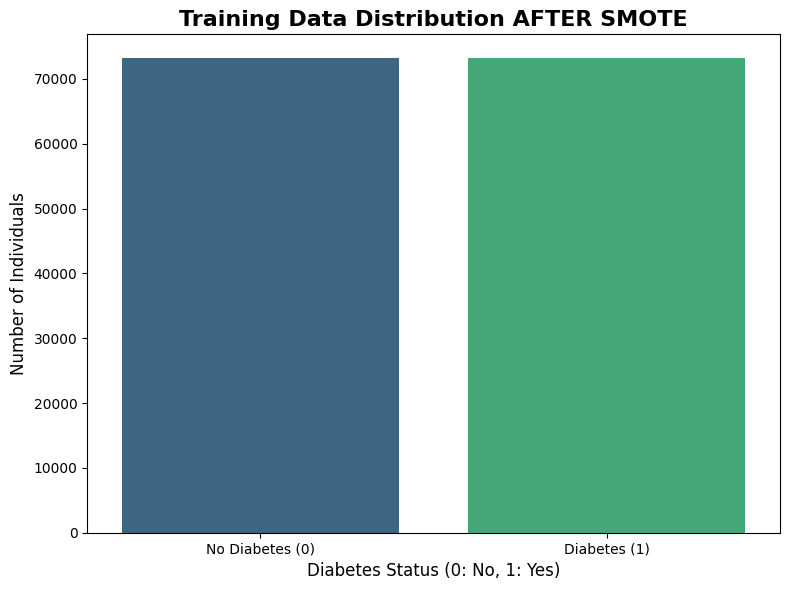


--- 7. Training and Evaluating Models ---
Training model: Logistic Regression...

--- Results for Logistic Regression ---
Accuracy: 0.8888
ROC AUC: 0.9629
Precision (Class 1): 0.4264
Recall (Class 1): 0.8935
F1-score (Class 1): 0.5773
Training model: Random Forest...

--- Results for Random Forest ---
Accuracy: 0.9695
ROC AUC: 0.9621
Precision (Class 1): 0.9311
Recall (Class 1): 0.6918
F1-score (Class 1): 0.7938
Training model: XGBoost...


/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:27:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Results for XGBoost ---
Accuracy: 0.9206
ROC AUC: 0.9769
Precision (Class 1): 0.5192
Recall (Class 1): 0.8900
F1-score (Class 1): 0.6558
Training model: LightGBM...
[LightGBM] [Info] Number of positive: 6800, number of negative: 73200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085000 -> initscore=-2.376273
[LightGBM] [Info] Start training from score -2.376273


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Results for LightGBM ---
Accuracy: 0.9152
ROC AUC: 0.9789
Precision (Class 1): 0.5006
Recall (Class 1): 0.9082
F1-score (Class 1): 0.6455
Training model: CatBoost...

--- Results for CatBoost ---
Accuracy: 0.9241
ROC AUC: 0.9779
Precision (Class 1): 0.5322
Recall (Class 1): 0.8853
F1-score (Class 1): 0.6648
Training model: SVM (RBF Kernel)...

--- Results for SVM (RBF Kernel) ---
Accuracy: 0.8963
ROC AUC: 0.9688
Precision (Class 1): 0.4465
Recall (Class 1): 0.9188
F1-score (Class 1): 0.6010
Training model: Naive Bayes...

--- Results for Naive Bayes ---
Accuracy: 0.4682
ROC AUC: 0.9128
Precision (Class 1): 0.1368
Recall (Class 1): 0.9900
F1-score (Class 1): 0.2404
Training model: K-Nearest Neighbors...

--- Results for K-Nearest Neighbors ---
Accuracy: 0.9116
ROC AUC: 0.9119
Precision (Class 1): 0.4880
Recall (Class 1): 0.8029
F1-score (Class 1): 0.6071
Training model: Gradient Boosting (with SMOTE)...

--- Results for Gradient Boosting (with SMOTE) ---
Accuracy: 0.9544
ROC AUC: 0

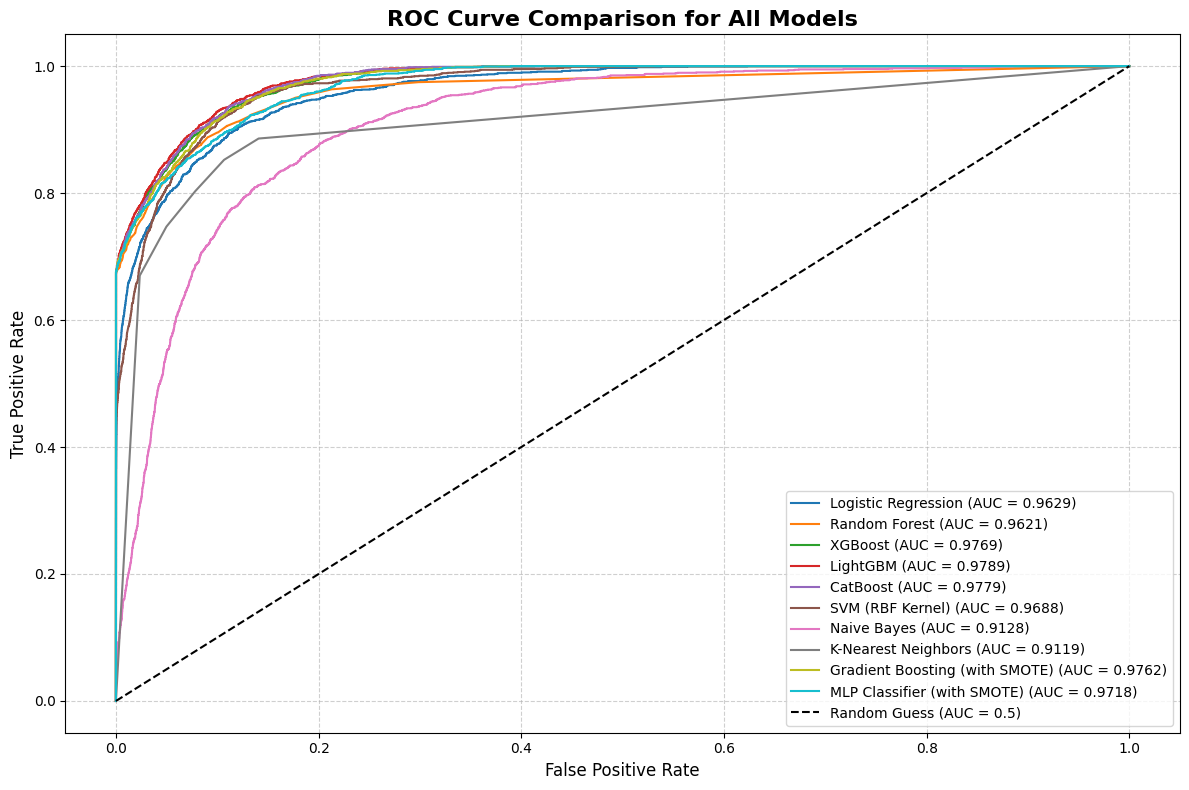


--- Visualizing Logistic Regression ---


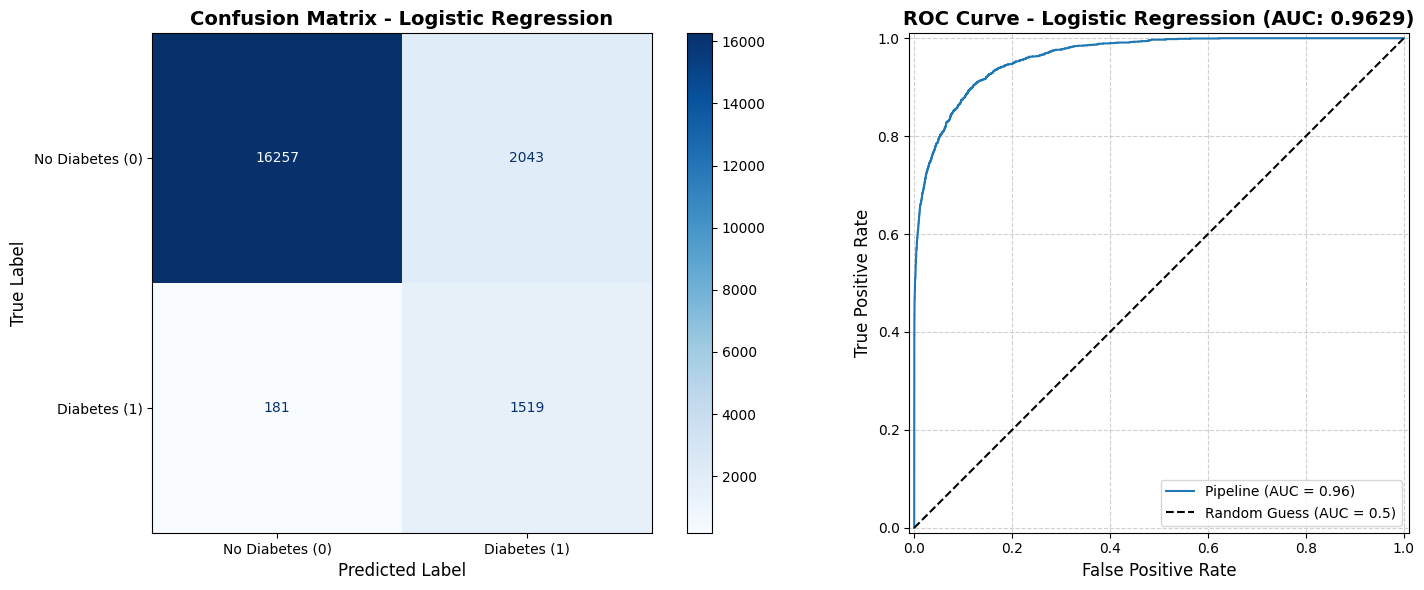


--- Visualizing Random Forest ---


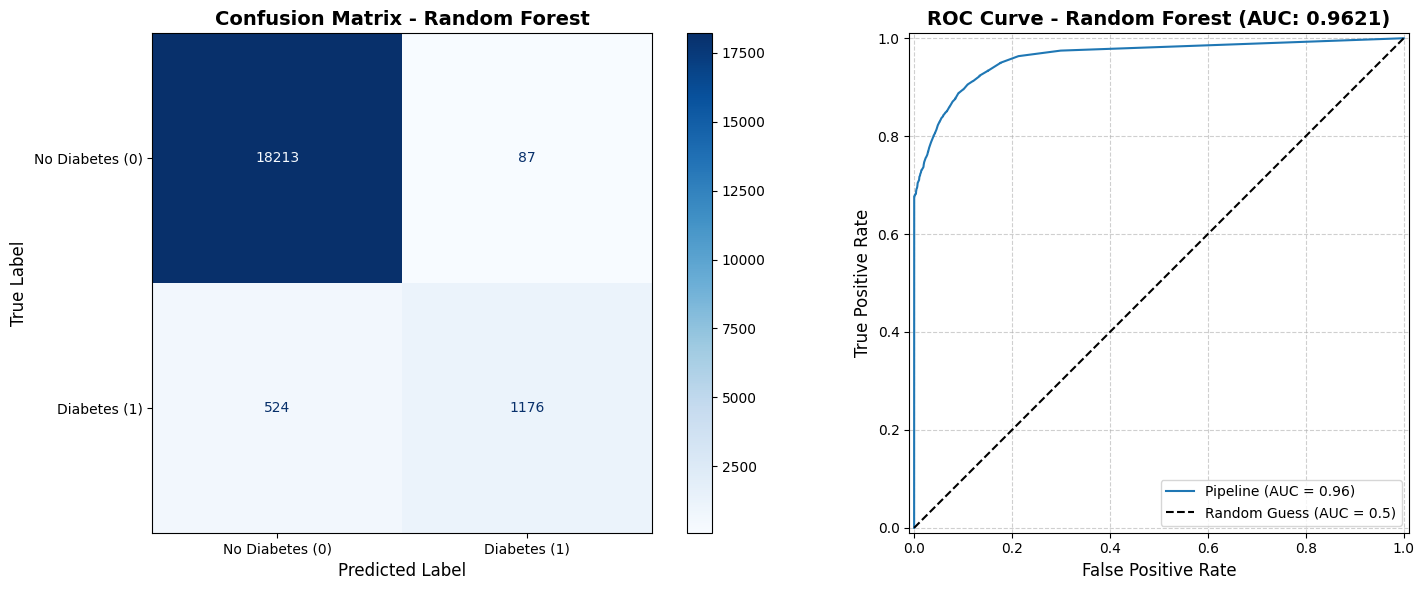


--- Visualizing XGBoost ---


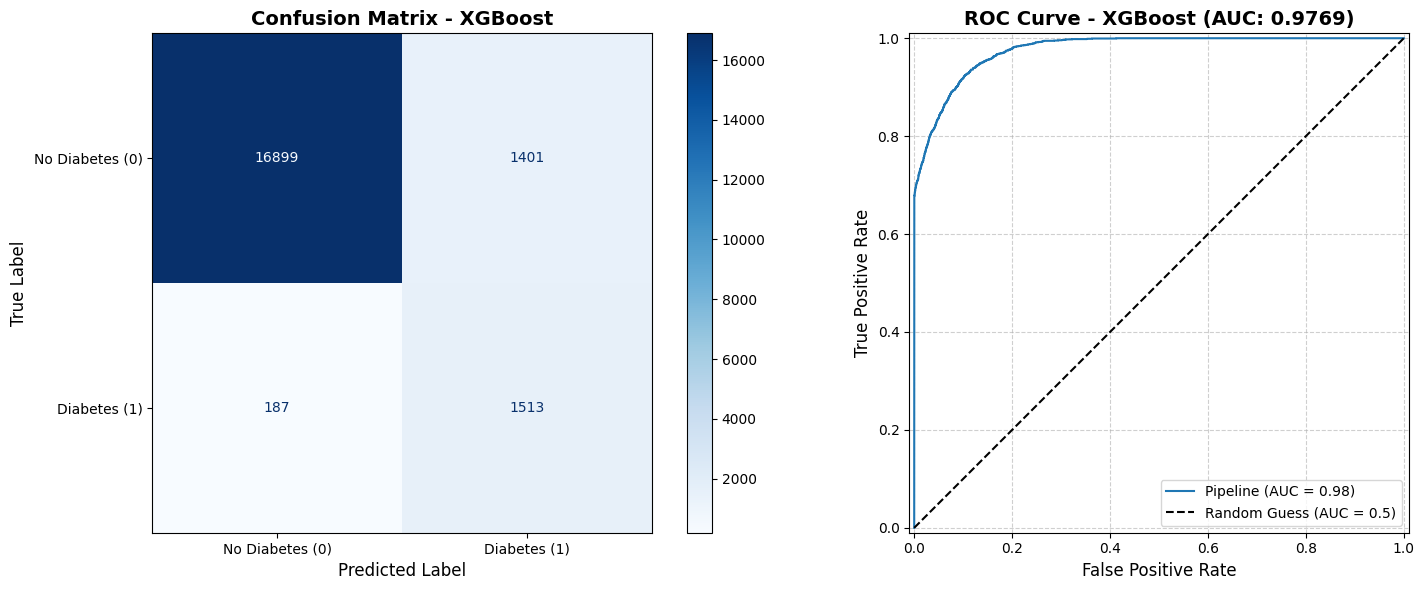


--- Visualizing LightGBM ---


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


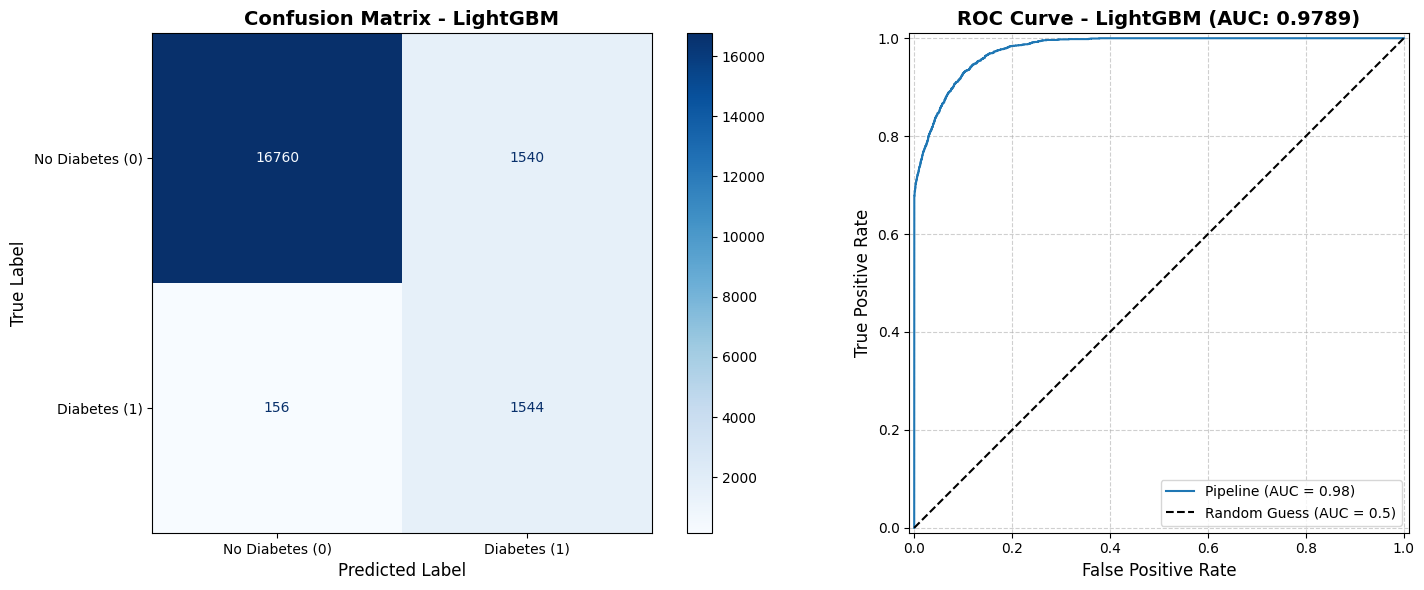


--- Visualizing CatBoost ---


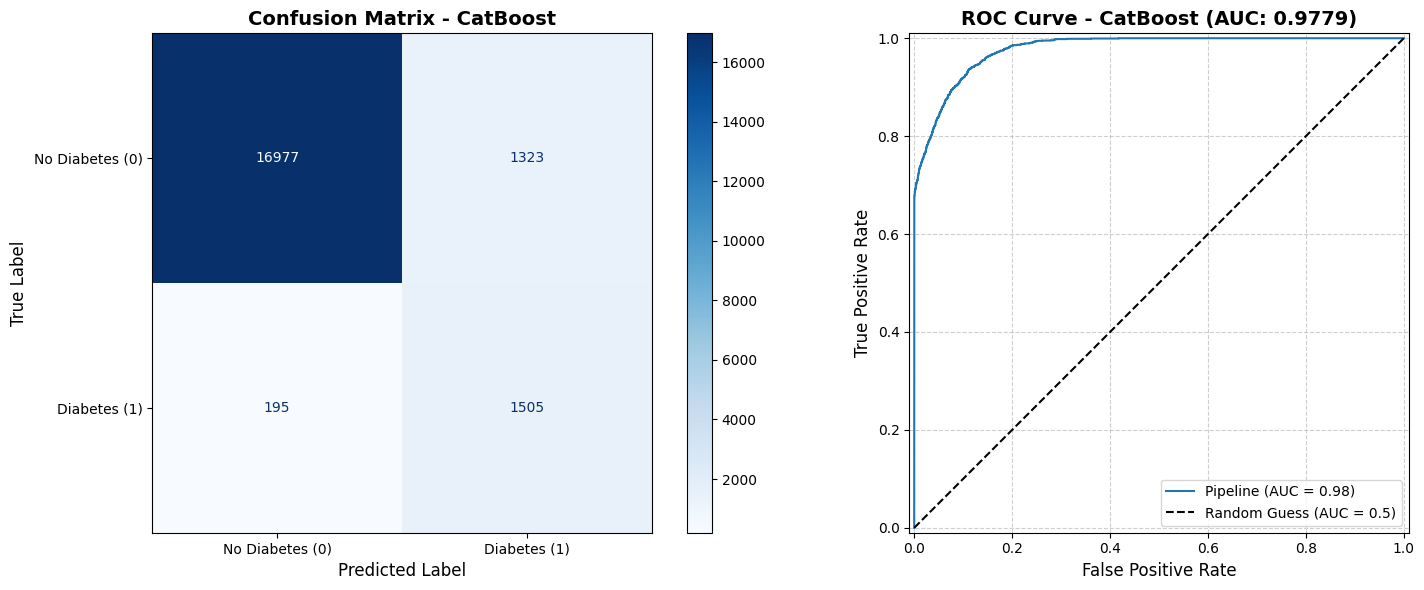


--- Visualizing SVM (RBF Kernel) ---


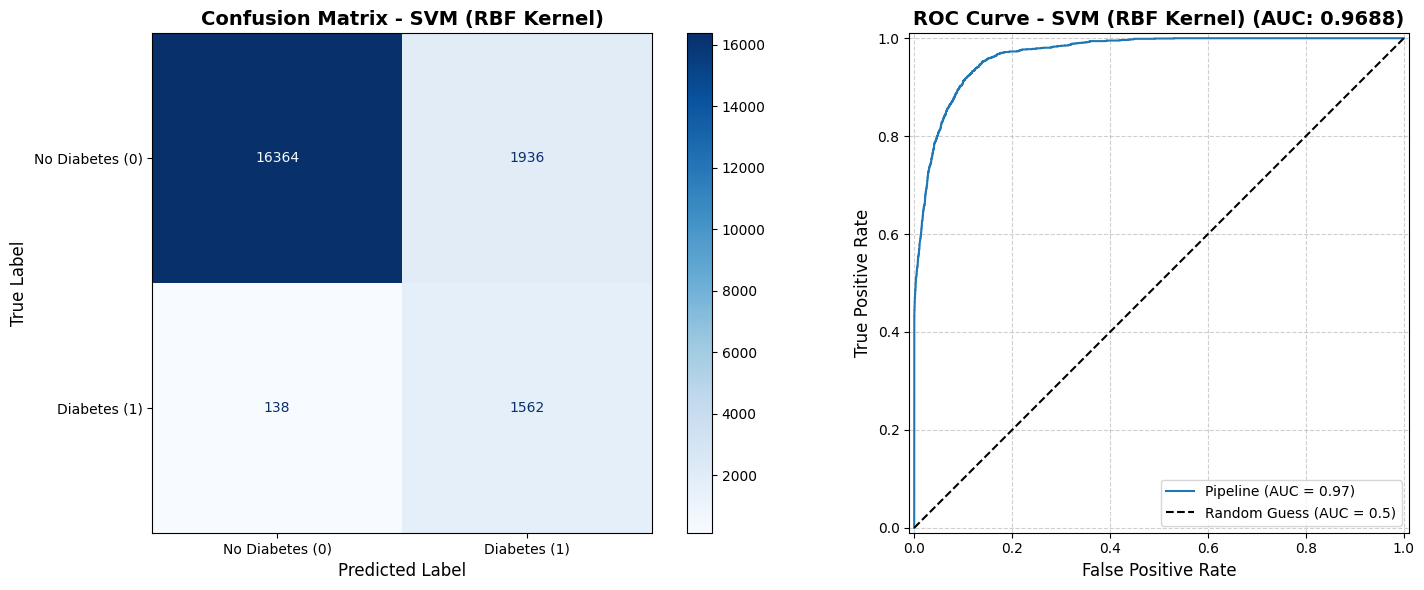


--- Visualizing Naive Bayes ---


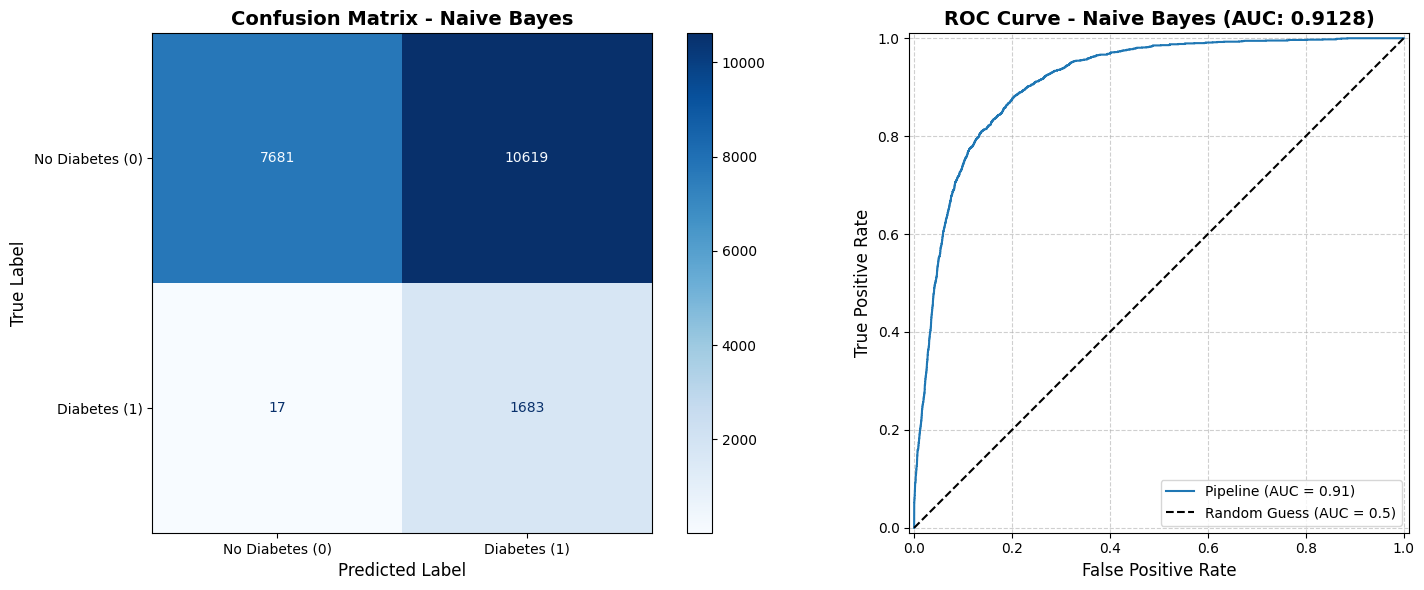


--- Visualizing K-Nearest Neighbors ---


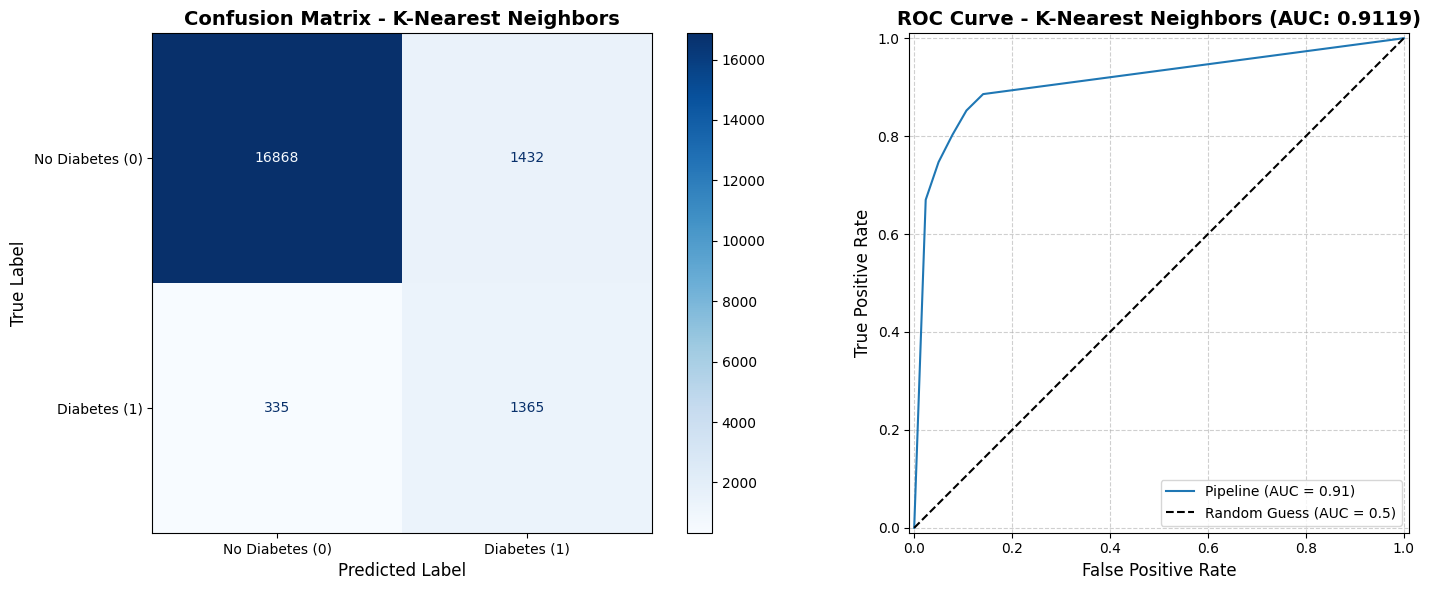


--- Visualizing Gradient Boosting (with SMOTE) ---


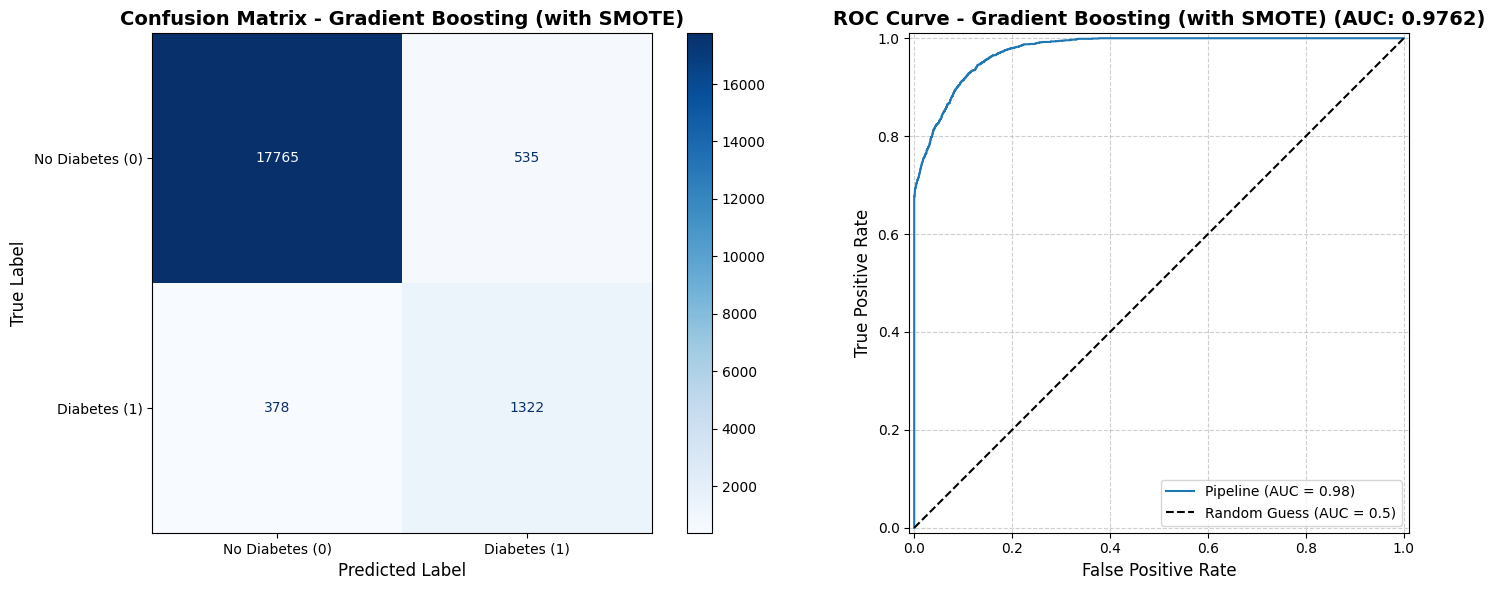


--- Visualizing MLP Classifier (with SMOTE) ---


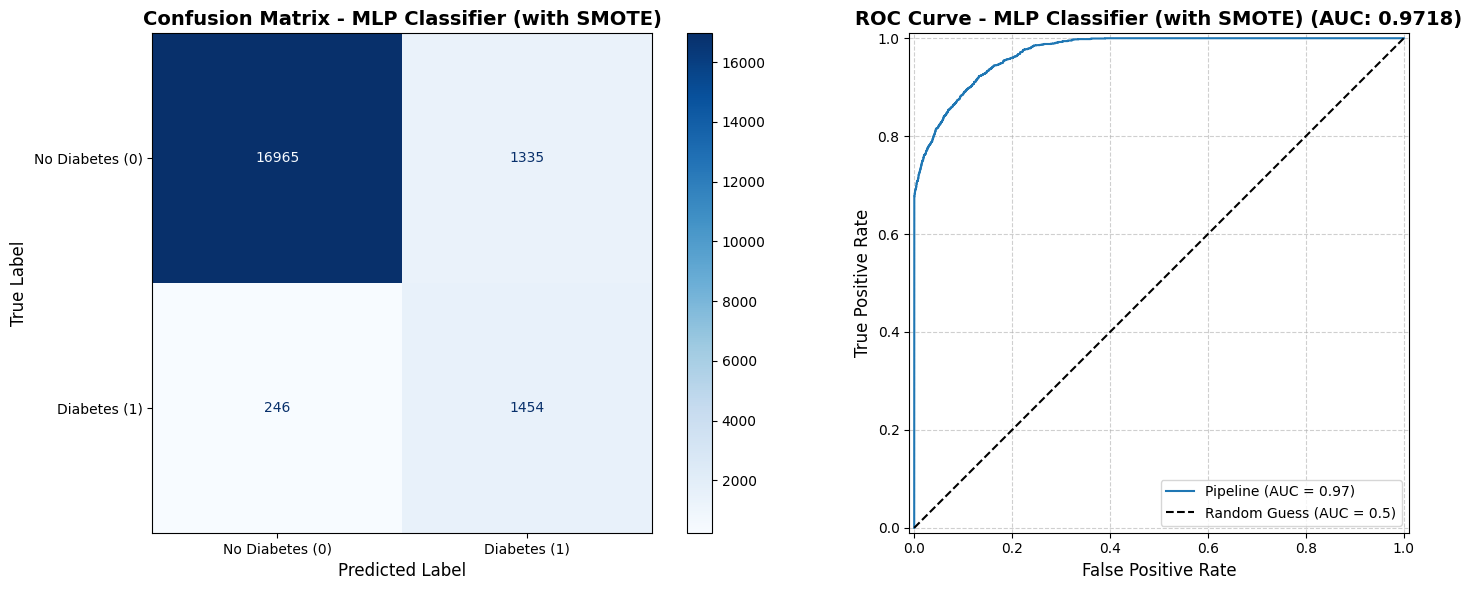


--- SHAP Explanation for the Best Model: LightGBM ---


/opt/homebrew/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


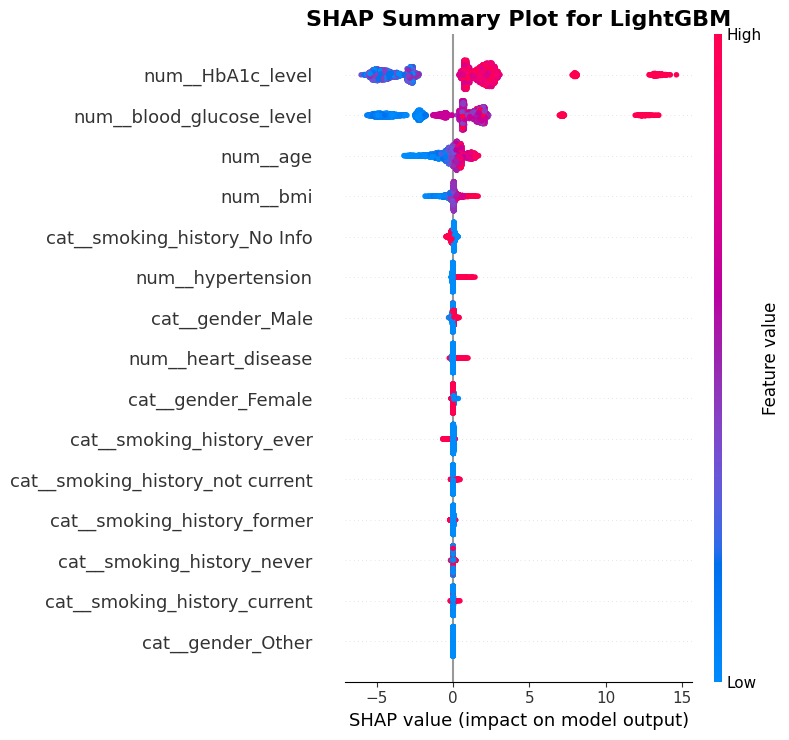

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For better plots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, \
                            ConfusionMatrixDisplay, RocCurveDisplay, f1_score, precision_score, recall_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC # Support Vector Machine
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron

# For handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's Pipeline for resampling steps

# For SHAP explanations
import shap

# --- 1. Load Data ---
# IMPORTANT: Replace "diabetes_prediction_dataset.csv" with your actual file path
try:
    df = pd.read_csv("diabetes_prediction_dataset.csv")
except FileNotFoundError:
    print("Error: 'diabetes_prediction_dataset.csv' not found.")
    print("Please ensure the CSV file is in the correct directory or provide the full path.")
    # Fallback to synthetic data if file not found, for demonstration purposes
    print("Generating synthetic data for demonstration...")
    np.random.seed(42)
    n_healthy = 91500
    n_diabetes = 8500
    df = pd.concat([
        pd.DataFrame({
            'gender': np.random.choice(['Female', 'Male'], n_healthy),
            'age': np.random.normal(40, 15, n_healthy).clip(20, 90).astype(int),
            'hypertension': np.random.choice([0, 1], n_healthy, p=[0.9, 0.1]),
            'heart_disease': np.random.choice([0, 1], n_healthy, p=[0.95, 0.05]),
            'smoking_history': np.random.choice(['never', 'No Info', 'former'], n_healthy, p=[0.6, 0.2, 0.2]),
            'bmi': np.random.normal(25, 5, n_healthy).clip(15, 50),
            'HbA1c_level': np.random.normal(5.5, 0.5, n_healthy).clip(4.0, 7.0),
            'blood_glucose_level': np.random.normal(100, 20, n_healthy).clip(70, 200).astype(int),
            'diabetes': np.zeros(n_healthy).astype(int)
        }),
        pd.DataFrame({
            'gender': np.random.choice(['Female', 'Male'], n_diabetes),
            'age': np.random.normal(60, 10, n_diabetes).clip(30, 90).astype(int),
            'hypertension': np.random.choice([0, 1], n_diabetes, p=[0.3, 0.7]),
            'heart_disease': np.random.choice([0, 1], n_diabetes, p=[0.6, 0.4]),
            'smoking_history': np.random.choice(['current', 'former', 'ever'], n_diabetes, p=[0.4, 0.3, 0.3]),
            'bmi': np.random.normal(30, 7, n_diabetes).clip(20, 60),
            'HbA1c_level': np.random.normal(7.5, 0.8, n_diabetes).clip(6.0, 10.0),
            'blood_glucose_level': np.random.normal(200, 50, n_diabetes).clip(140, 300).astype(int),
            'diabetes': np.ones(n_diabetes).astype(int)
        })
    ], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

    # Introduce some artificial NaNs for demonstration
    for col in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
        missing_indices = np.random.choice(df.index, size=int(len(df) * 0.01), replace=False)
        df.loc[missing_indices, col] = np.nan
    missing_cat_indices = np.random.choice(df.index, size=int(len(df) * 0.005), replace=False)
    df.loc[missing_cat_indices, 'smoking_history'] = np.nan


# Drop rows where 'diabetes' target itself is NaN (if any)
df.dropna(subset=["diabetes"], inplace=True) # Ensure target column has no NaNs
X = df.drop(columns="diabetes")
y = df["diabetes"]

print("--- Data Loaded ---")
print(df.head())
print(df.info())

# --- 2. Initial Data Analysis (Missing Values and Class Imbalance) ---
print("\n--- Missing Values Count (Before Imputation) ---")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

# Visualize Class Imbalance (Pre-SMOTE)
plt.figure(figsize=(8, 6))
sns.countplot(x='diabetes', data=df, palette='viridis')
plt.title('Original Distribution of Diabetes (Pre-SMOTE)', fontsize=16, fontweight='bold')
plt.xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.show()

# --- 3. Column Identification & Preprocessing Pipelines ---
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# --- 4. Train/Test Split (Stratified is CRUCIAL) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTraining set class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test.value_counts(normalize=True)}")

# --- 5. Plotting Post-SMOTE Distribution ---
# Create a temporary pipeline to apply preprocessor and SMOTE on training data for visualization
smote_instance_for_plot = SMOTE(sampling_strategy='auto', random_state=42)
smote_pipeline_for_plotting = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", smote_instance_for_plot)
])

# Fit and transform X_train, y_train to get the resampled data for plotting
print("\n--- Applying Preprocessing and SMOTE to Training Data for Visualization ---")
X_train_resampled_plot, y_train_resampled_plot = smote_pipeline_for_plotting.fit_resample(X_train, y_train)

print(f"\nTraining set size AFTER SMOTE: {len(X_train_resampled_plot)} samples")
print(f"Training set class distribution AFTER SMOTE:\n{y_train_resampled_plot.value_counts(normalize=True)}")

# Visualize Class Distribution AFTER SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled_plot, palette='viridis')
plt.title('Training Data Distribution AFTER SMOTE', fontsize=16, fontweight='bold')
plt.xlabel('Diabetes Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.show()


# --- 6. Define Models with Class Balancing & SMOTE Integration ---
# Calculate scale_pos_weight for XGBoost based on original training data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define the SMOTE instance to be used within ImbPipelines
smote_instance = SMOTE(sampling_strategy='auto', random_state=42)

models_config = {
    "Logistic Regression": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "Random Forest": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "XGBoost": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric="logloss", random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal scale_pos_weight
    },
    "LightGBM": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LGBMClassifier(is_unbalance=True, random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal is_unbalance
    },
    "CatBoost": {
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", CatBoostClassifier(verbose=0, auto_class_weights='Balanced', random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal auto_class_weights
    },
    "SVM (RBF Kernel)": { # SVM is computationally expensive, reducing max_iter for faster demo
        "pipeline": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
        ]),
        "use_smote_pipeline": False # Uses internal class_weight
    },
    "Naive Bayes": {
        "pipeline": ImbPipeline([ # GaussianNB doesn't have class_weight, so use SMOTE
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", GaussianNB())
        ]),
        "use_smote_pipeline": True
    },
    "K-Nearest Neighbors": {
        "pipeline": ImbPipeline([ # KNN benefits greatly from balanced data
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", KNeighborsClassifier())
        ]),
        "use_smote_pipeline": True
    },
    "Gradient Boosting (with SMOTE)": { # GradientBoostingClassifier does not have direct class_weight, benefits from SMOTE
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", GradientBoostingClassifier(random_state=42))
        ]),
        "use_smote_pipeline": True
    },
    "MLP Classifier (with SMOTE)": { # MLP can benefit from balanced data
        "pipeline": ImbPipeline([
            ("preprocessor", preprocessor),
            ("smote", smote_instance),
            ("classifier", MLPClassifier(max_iter=1000, random_state=42))
        ]),
        "use_smote_pipeline": True
    }
}

results = {}
best_roc_auc = -1
best_model_name = ""

print("\n--- 7. Training and Evaluating Models ---")
for name, config in models_config.items():
    print(f"Training model: {name}...")
    model_pipeline = config["pipeline"]

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1] if hasattr(model_pipeline.named_steps["classifier"], "predict_proba") else None

    # Calculate metrics
    accuracy = (y_test == y_pred).mean()
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['No Diabetes (0)', 'Diabetes (1)'], output_dict=True)

    results[name] = {
        "model": model_pipeline,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

    print(f"\n--- Results for {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Precision (Class 1): {precision:.4f}")
    print(f"Recall (Class 1): {recall:.4f}")
    print(f"F1-score (Class 1): {f1:.4f}")
    # print(classification_report(y_test, y_pred, target_names=['No Diabetes (0)', 'Diabetes (1)']))

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model_name = name

print(f"\n✅ Best Model identified by ROC AUC: {best_model_name} with ROC AUC = {best_roc_auc:.4f}")


# --- 8. Comprehensive Plotting for Each Model ---

# Overall ROC Curve Comparison
plt.figure(figsize=(12, 8))
for name in results:
    if results[name]["y_prob"] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]["y_prob"])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.5)")
plt.title("ROC Curve Comparison for All Models", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Individual Confusion Matrices and ROC Curves
for name, res in results.items():
    print(f"\n--- Visualizing {name} ---")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns

    # Confusion Matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=res["confusion_matrix"],
                                        display_labels=['No Diabetes (0)', 'Diabetes (1)'])
    cm_display.plot(cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].grid(False) # Remove grid from confusion matrix

    # ROC Curve
    if res["y_prob"] is not None:
        RocCurveDisplay.from_estimator(res["model"], X_test, y_test, ax=axes[1])
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
        axes[1].set_title(f'ROC Curve - {name} (AUC: {res["roc_auc"]:.4f})', fontsize=14, fontweight='bold')
        axes[1].set_xlabel("False Positive Rate", fontsize=12)
        axes[1].set_ylabel("True Positive Rate", fontsize=12)
        axes[1].legend(fontsize=10)
        axes[1].grid(True, linestyle="--", alpha=0.6)
    else:
        axes[1].text(0.5, 0.5, "ROC Curve Not Applicable\n(No predict_proba)", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12, color='red')
        axes[1].set_title(f'ROC Curve - {name}', fontsize=14, fontweight='bold')
        axes[1].set_xlabel("False Positive Rate", fontsize=12)
        axes[1].set_ylabel("True Positive Rate", fontsize=12)

    plt.tight_layout()
    plt.show()


# --- 9. SHAP Explanations for the Best Model ---
print(f"\n--- SHAP Explanation for the Best Model: {best_model_name} ---")

best_model_pipeline = results[best_model_name]["model"]

# Extract the classifier and preprocessor from the best model's pipeline
classifier_model_final = None
preprocessor_final = None

if isinstance(best_model_pipeline, ImbPipeline):
    classifier_model_final = best_model_pipeline.named_steps["classifier"]
    preprocessor_final = best_model_pipeline.named_steps["preprocessor"]
elif isinstance(best_model_pipeline, Pipeline):
    classifier_model_final = best_model_pipeline.named_steps["classifier"]
    preprocessor_final = best_model_pipeline.named_steps["preprocessor"]

if classifier_model_final and preprocessor_final:
    # Get feature names after preprocessing
    feature_names_out = preprocessor_final.get_feature_names_out()

    # Determine which explainer to use
    if hasattr(classifier_model_final, "feature_importances_") or \
       isinstance(classifier_model_final, (XGBClassifier, RandomForestClassifier, GradientBoostingClassifier, CatBoostClassifier, LGBMClassifier)):
        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(classifier_model_final)
        # Use a subset of the preprocessed X_test for SHAP values to balance speed and accuracy
        # Ensure X_test is transformed with the same preprocessor as used in the pipeline
        X_test_transformed_shap = preprocessor_final.transform(X_test)
        # Limit the number of samples for SHAP calculation to avoid long runtimes
        # If your data is very large, consider a smaller sample (e.g., 1000 or 500)
        sample_size = min(5000, X_test_transformed_shap.shape[0])
        shap_values = explainer.shap_values(X_test_transformed_shap[:sample_size])
        shap_features = X_test_transformed_shap[:sample_size]
    else:
        # Use KernelExplainer for non-tree-based models (e.g., Logistic Regression, SVM, KNN, Naive Bayes, MLP)
        # It requires a background dataset. Using a subset of X_train_resampled_plot for this.
        # This part requires X_train_resampled_plot to be accessible.
        # X_train_resampled_plot was generated earlier for the SMOTE plot.
        if 'y_train_resampled_plot' in locals() and X_train_resampled_plot is not None:
            # Taking a small sample for KernelExplainer's background data for speed
            background_data = shap.utils.sample(X_train_resampled_plot, 100) # Use 100 samples for background
            explainer = shap.KernelExplainer(classifier_model_final.predict_proba, background_data)
            # Use a subset of the preprocessed X_test for SHAP values
            X_test_transformed_shap = preprocessor_final.transform(X_test)
            sample_size = min(500, X_test_transformed_shap.shape[0]) # Even smaller sample for KernelExplainer's values
            shap_values = explainer.shap_values(X_test_transformed_shap[:sample_size])
            shap_features = X_test_transformed_shap[:sample_size]
        else:
            print("Cannot generate SHAP explanation for non-tree models without transformed training data.")
            shap_values = None # Indicate that SHAP values could not be generated

    if shap_values is not None:
        # For binary classification, shap_values is a list of arrays (one for each class).
        # We usually plot for the positive class (class 1).
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap.summary_plot(shap_values[1], shap_features, feature_names=feature_names_out, show=False)
        else: # For single output models or direct feature importances
            shap.summary_plot(shap_values, shap_features, feature_names=feature_names_out, show=False)
        plt.title(f"SHAP Summary Plot for {best_model_name}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("SHAP values could not be generated for plotting.")
else:
    print("Could not retrieve classifier or preprocessor for SHAP explanation.")
    